# Import packages and functions

In [48]:
import numpy as np
import pandas as pd 
from random import randint
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import log_loss, accuracy_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy import sparse
from io import BytesIO
from urllib.request import urlopen
import requests
import pickle
from datetime import datetime

# Defined functions in the .py files
from read_data import read_train_val_graph, read_and_clean_authors
from data_processing_graph import create_and_normalize_adjacency
from data_processing_authors import authors_to_sparse_mx

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load data from files

### Graph

In [30]:
t = time()
G, G_train, train_edges, val_indices, y_val, nodes, node_to_idx = read_train_val_graph()
adj, indices = create_and_normalize_adjacency(G_train)

print('Graph loaded and seperated, adjacency matrix created and normalized in {:.0f} s'.format(time()-t))

Number of nodes: 138499 number of edges: 1091955 in the Complete set
Number of nodes: 138499 number of edges: 982062 in the Training set
len(nodes) 138499
Returned G_train, train_edges, val_edges, y_val, nodes and node_to_idx objects
Loaded from edgelist.txt and with a training validation split ratio = 0.1


/Users/ghassenabdedayem/Documents/Data/Polytechnique/5- Data Challenge/data_challenge_2022/data_processing_graph.py:19: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix of the training graph


Created a normalized adjancency matrix of shape (138499, 138499)
Created indices (2, 2102623) with the positions of non zeros in adj matrix
Graph loaded and seperated, adjacency matrix created and normalized in 15 s


### Authors

In [7]:
t = time()

# We read authors and transform them into a sparse one hot vector representation
auth_matrix = authors_to_sparse_mx(read_and_clean_authors())

# Then we will reduce the dimensionality of authors matrix using TruncatedSVD
n_components = 192  # Adjust the number of components as needed
svd = TruncatedSVD(n_components=n_components)

# Apply TruncatedSVD to the authors matrix
authors_reduced = svd.fit_transform(auth_matrix)

print('Authors loaded, transfomed and reduced to a {} matrix in {:.0f} sec'.format(authors_reduced.shape, time()-t))

Authors loaded, transfomed and reduced to a (138499, 192) matrix in 20 sec


# Load preprocessed data

### Random walks

In [15]:
t = time()
walks_url = 'https://storage.googleapis.com/link_prediction_processed_data/walks_wv.npy'
with urlopen(walks_url) as url:
    data = url.read()

# Create a seekable file-like object from the data
fileobj = BytesIO(data)

# Load the data from the file object
walks_wv = np.load(fileobj)
print('wv walks of shape {} loaded from GCP in {:.0f} sec'.format(walks_wv.shape, time()-t))

wv walks of shape (138499, 64) loaded from GCP in 0 sec


### BERT embedding

In [21]:
# Load BERT abstract embedding

url = 'https://storage.googleapis.com/link_prediction_processed_data/sentence_embeddings_BERT.plk'

response = requests.get(url)
data = response.content
bert_abstract_embedding = pickle.loads(data)

### TF-IDF with authors

In [22]:
# Load TF-IDF matrix of the abstracts concatenated with their respective authors

url = "https://storage.googleapis.com/link_prediction_processed_data/tfidf_author.npz"

response = requests.get(url)

with open("tfidf_matrix.npz", "wb") as f:
    f.write(response.content)

tfidf_matrix = sparse.load_npz("tfidf_matrix.npz")

tfidf_matrix.shape

(138499, 136437)

In [23]:
# Reduce the TF-IDF matrix using TrunkatedSVD
t = time()

# Initialize TruncatedSVD with desired number of components
n_components = 768  # Adjust the number of components as needed
svd = TruncatedSVD(n_components=n_components)

# Apply TruncatedSVD to the TF-IDF matrix
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# The tfidf_reduced matrix will have the reduced dimensionality based on TruncatedSVD
print('tfidf reduced to {} shape in {:.0f} min to {}'.format(tfidf_reduced.shape, (time()-t)/60, tfidf_reduced.shape))


tfidf reduced to (138499, 768) shape in 2 min to (138499, 768)


# Model

In [24]:
class GNN(nn.Module):
    def __init__(self, n_text, n_text_auth, n_auth, n_feat, n_hidden, n_class, sub_class, dropout):
        super(GNN, self).__init__()
        self.abstract_emb = nn.Linear(n_text_auth, n_hidden)
        # self.abst_auth = nn.Linear(n_text_auth, n_hidden)
        self.auth_emb = nn.Linear(n_auth, n_hidden)
        self.fc1 = nn.Linear(n_feat+2*n_hidden, n_hidden)        
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc21 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(2*n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, sub_class)
        self.fc5 = nn.Linear(sub_class, n_class)        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.norm = nn.LayerNorm(n_auth+n_text+n_feat+n_text_auth)
        
        

    def forward(self, x_in, abstract, abst_auth, auth, adj, pairs):

        #y = torch.cat((abstract, abst_auth, auth, x_in), dim=1)
        #y = torch.cat((abstract, auth, abst_auth, x_in), dim=1)
        #y = self.norm(y)
        y = self.abstract_emb(abstract)
        y = self.relu(y)
        y = self.dropout(y)
        del(abstract)

        # yz = self.abst_auth(abst_auth)
        # yz = self.relu(yz)
        # yz = self.dropout(yz)
        del(abst_auth)

        z = self.auth_emb(auth)
        z = self.relu(z)
        z = self.dropout(z)
        del(auth)

        x_in = torch.cat((x_in, y, z), dim=1)

        
        h1 = self.fc1(x_in)
        z1 = self.relu(torch.spmm(adj, h1))
        z1 = self.dropout(z1)
        #del(y)

        h2 = self.fc2(z1)
        z2 = self.relu(torch.spmm(adj, h2))
        z2 = self.dropout(z2)
        del(h2, z1)

        h2 = self.fc21(z2)
        z2 = self.relu(torch.spmm(adj, h2))
        z2 = self.dropout(z2)


        z2 = torch.cat((z2, h1), dim=1)

        x = z2[pairs[0]] - z2[pairs[1]]
        # x = torch.cat((z2[pairs[0]] , z2[pairs[1]]), dim=1)
        del(z2)

        x = self.relu(self.fc3(x))
        x = self.dropout(x)
    
        del(pairs)
        
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)




In [25]:
def train_model(model, learning_rate, abstract, text_auth, auth, features, adj, indices, val_edges, epochs, run_number, window = 10):
    # Train model
    start_time = time()
    
    print('Initializing the optimizer with learning rate:', learning_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #optimizer with halving learning rate in training
    try: os.mkdir('./outputs')
    except: pass

    today = datetime.today().strftime('%Y-%m-%d-%H:%M')
    list_loss_val = []
    list_loss_train = []
    list_epochs = []

    


    # Create negative edges by taking a random pairs of nodes (there is 1/10,000 chance of getting a positive edge)
    rand_indices = torch.randint(0, features.shape[0], size=(indices.shape[0],indices.shape[1])).to(device)
    pairs = torch.cat((indices, rand_indices), dim=1)
    
    # Create class labels
    y = np.zeros(2*indices.shape[1])
    y[:indices.shape[1]] = 1 # Concatenated ones for edges indices and later in the model we add zeros for random indices.
    y = torch.LongTensor(y).to(device)

    # Creating negative val indices by taking random pairs of nodes
    rand_indices = torch.randint(0, features.shape[0], size=(val_edges.shape[0],val_edges.shape[1])).to(device)
    val_indices = torch.cat((val_edges, rand_indices), dim=1)
    
    # Creating class labels for val indices
    y_val = [1]*len(val_edges)
    y_val.extend([0]*len(val_edges))
    
    print('Start training...')

    for epoch in range(epochs):
        t = time()
        optimizer.zero_grad()     

        model.train()
        output = model(features, abstract, text_auth, auth, adj, pairs).to(device) # we run the model that gives the output.
        loss_train = F.nll_loss(output, y) # we are using nll_loss as loss to optimize, we store it in loss_train. We compare to y which is stable and contains the tag ones and zeros.
        acc_train = accuracy_score(torch.argmax(output, dim=1).detach().cpu().numpy(), y.cpu().numpy())# just to show it in the out put message of the training
        loss_train.backward() # The back propagation ? --> Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # Performs a single optimization step (parameter update).
        
        model.eval()
        output = model(features, abstract, text_auth, auth, adj, val_indices).to(device)
        #y_val = torch.LongTensor(y_val).to(device)
        loss_val = F.nll_loss(output, y_val)
        list_loss_val.append(loss_val.item())
        list_loss_train.append(loss_train.item())
        list_epochs.append(epoch)
        acc_val = accuracy_score(torch.argmax(output, dim=1).detach().cpu().numpy(), y_val.cpu().numpy())        


        if epoch % 5 == 0:
            print('Epoch: {:03d}'.format(epoch+1),
                  'loss_train: {:.4f}'.format(loss_train.item()),
                  'loss_val: {:.4f}'.format(loss_val.item()),
                  'acc_train: {:.4f}'.format(acc_train.item()),
                  'acc_val: {:.4f}'.format(acc_val.item()),
                  'time: {} s'.format(int(round(time()) - round(t))),
                 'total_time: {} min'.format(round((time() - start_time)/60)))
            


    print("Optimization Finished in {} min!".format(round((time() - start_time)/60)))
    return model, list_loss_val, list_loss_train, list_epochs



In [32]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def prepare_data_to_train (features, adj, auth_matrix, indices, val_indices, y_val):
    
    print('Preparing the data for training...')
    
    t = time()
    
    y_val = torch.LongTensor(y_val).to(device)
    
    features = torch.FloatTensor(features).to(device)
    
    indices = torch.LongTensor(indices).to(device)
    val_indices = torch.LongTensor(val_indices).to(device)
    adj = sparse_mx_to_torch_sparse_tensor(adj).to(device)
    auth_matrix = sparse_mx_to_torch_sparse_tensor(auth_matrix).to(device)
    
    print('Data converted into torch tensors in {:.0f} min'.format((time()-t)/60))

    return features, adj, auth_matrix, indices, val_indices, y_val 

In [33]:
features_torch, adj_torch, auth_torch, indices_torch, val_indices_torch, y_val_torch = prepare_data_to_train(walks_wv, adj, auth_matrix, indices, val_indices, y_val)
tfidf_matrix_torch = torch.FloatTensor(tfidf_reduced).to(device)
authors_reduced_torch = torch.FloatTensor(authors_reduced).to(device)
bert_abstract_torch = torch.FloatTensor(bert_abstract_embedding).to(device)

Preparing the data for training...
Data converted into torch tensors and authors added to indices in 0 min


In [44]:
torch.cuda.empty_cache()

#Create the model
n_hidden = 64
dropout_rate = 0.2
sub_class = 16
n_class = 2
text_embedding = bert_abstract_torch
text_auth_emb = tfidf_matrix_torch
n_text = text_embedding.shape[1]
n_text_auth = text_auth_emb.shape[1]
n_auth = authors_reduced_torch.shape[1] 
n_features = features_torch.shape[1]

model = GNN(n_text, n_text_auth, n_auth, n_features, n_hidden, n_class, sub_class, dropout_rate).to(device)


# Train the model
epochs = 140
run_number = randint(0, 1000)
learning_rate = 0.01

trained_model, list_loss_val, list_loss_train, list_epochs = train_model(model, learning_rate, text_embedding, 
                            text_auth_emb, authors_reduced_torch, features_torch, adj_torch, indices_torch, 
                            val_indices_torch, y_val_torch, epochs, run_number)


Initializing the optimizer with learning rate: 0.01
Start training...
Epoch: 001 loss_train: 0.6923 loss_val: 0.6807 acc_train: 0.5327 acc_val: 0.5031 time: 18 s total_time: 0 min
Epoch: 006 loss_train: 0.5559 loss_val: 0.5283 acc_train: 0.7170 acc_val: 0.7492 time: 8 s total_time: 1 min
Epoch: 011 loss_train: 0.4391 loss_val: 0.4037 acc_train: 0.8320 acc_val: 0.8547 time: 10 s total_time: 2 min
Epoch: 016 loss_train: 0.3299 loss_val: 0.3163 acc_train: 0.8700 acc_val: 0.8741 time: 8 s total_time: 3 min
Epoch: 021 loss_train: 0.2675 loss_val: 0.2478 acc_train: 0.8932 acc_val: 0.9002 time: 9 s total_time: 3 min
Epoch: 026 loss_train: 0.2229 loss_val: 0.2076 acc_train: 0.9140 acc_val: 0.9182 time: 9 s total_time: 4 min
Epoch: 031 loss_train: 0.2014 loss_val: 0.1856 acc_train: 0.9234 acc_val: 0.9275 time: 9 s total_time: 5 min
Epoch: 036 loss_train: 0.1920 loss_val: 0.1818 acc_train: 0.9274 acc_val: 0.9284 time: 9 s total_time: 6 min
Epoch: 041 loss_train: 0.1791 loss_val: 0.1701 acc_train

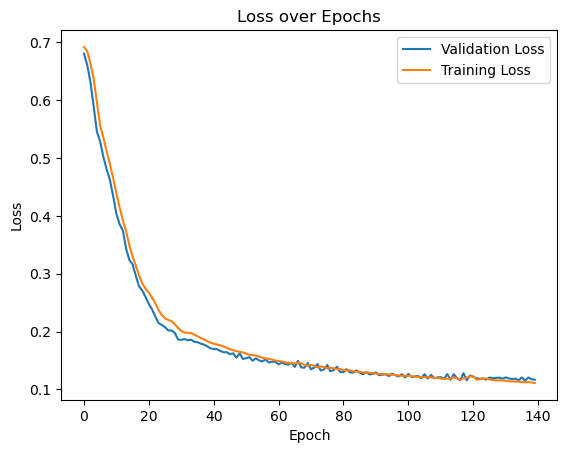

In [49]:
%matplotlib inline

length = 200

y1 = pd.Series(list_loss_val[:length])
y2 = pd.Series(list_loss_train[:length])
x = pd.Series(list_epochs[:length])




plt.plot(x, y1, label='Validation Loss')
plt.plot(x, y2, label='Training Loss')

plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate test file

In [47]:
from datetime import datetime
import re

test_path = 'https://www.lix.polytechnique.fr/~nikolentzos/files/aai/challenge/test.txt'
node_pairs = list()
f = urlopen(test_path)

for line in f:
    t = str(line).split(',')
    t[0] = int(re.sub("[^0-9]", "", t[0]))
    t[1] = int(re.sub("[^0-9]", "", t[1]))
    node_pairs.append((node_to_idx[int(t[0])], node_to_idx[int(t[1])]))

node_pairs = np.transpose(node_pairs)
#node_pairs = add_authors_to_pairs(node_pairs, authors)
#node_pairs = torch.LongTensor(node_pairs).to(device)

adj_torch = sparse_mx_to_torch_sparse_tensor(adj).to(device)
features_torch = torch.FloatTensor(walks_wv).to(device)

test_output = model(features_torch, text_embedding, text_auth_emb, authors_reduced_torch, adj_torch, node_pairs)
y_pred = torch.exp(test_output)
y_pred = y_pred.detach().cpu().numpy()

y_pred_true = list()
for element in y_pred:
    y_pred_true.append(element[1])

today = datetime.today().strftime('%Y-%m-%d')
random_nb = randint(0, 1000)
model_nb = 2

pd.DataFrame(y_pred_true, columns=['predicted']).to_csv(
"{}-submission-{}-{}.csv".format(today, model_nb, random_nb), header=True, index=True, index_label='id'
)